In [12]:
from utils.db import load_all_rows_from_mongo
from utils.functions import processar_indicadores_financeiros, prophet_ar2_forecast, forecast_future_periods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
#from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
all_rows = load_all_rows_from_mongo(coll_name="industrial_nordeste")

df_hist = pd.DataFrame(all_rows)
indicadores_historicos = processar_indicadores_financeiros(df_hist)

In [13]:
indicadores_historicos['Margem_de_Lucro'] = np.log1p(
    indicadores_historicos['Margem_de_Lucro'])

In [6]:
resultado = adfuller(indicadores_historicos['Margem_de_Lucro'])
p_valor = resultado[1]

print(f"p-valor: {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série é estacionária (rejeita H₀).")
else:
    print("⚠️ A série NÃO é estacionária (não rejeita H₀). O Prophet consegue lidar com isso.")

p-valor: 0.0000
✅ A série é estacionária (rejeita H₀).


In [18]:
lb = acorr_ljungbox(indicadores_historicos['Margem_de_Lucro'], lags=[
                    3], return_df=True)
p_valor = lb['lb_pvalue'].iloc[-1]  # pega o p-valor do último lag

print(lb)
print(f"\nP-valor (lag 12): {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série apresenta autocorrelação significativa (rejeita H₀).")
else:
    print("⚠️ A série NÃO apresenta autocorrelação significativa (não rejeita H₀).")

    lb_stat  lb_pvalue
3  8.550349   0.035907

P-valor (lag 12): 0.0359
✅ A série apresenta autocorrelação significativa (rejeita H₀).


In [ ]:
indicadores_historicos.index = pd.to_datetime(
    indicadores_historicos.index, format="%Y-%m")

In [27]:

resultado = prophet_ar2_forecast(
    indicadores_historicos, target_col='Liquidez_Imediata', horizon=6)

# acessar métricas
print(resultado['MAE'], resultado['RMSE'], resultado['MAPE'])

# visualizar previsões
print(resultado['forecast_df'])

21:59:15 - cmdstanpy - INFO - Chain [1] start processing
21:59:15 - cmdstanpy - INFO - Chain [1] done processing


📈 AR(2) via Prophet - coluna: Liquidez_Imediata
MAE :  0.2152
RMSE:  0.2674
MAPE:  27.58%
0.21520516945348997 0.2673515575588584 27.576444976808528
          ds    y_true    y_pred
0 2024-07-01  0.727312  0.758690
1 2024-08-01  0.791949  0.783192
2 2024-09-01  0.619650  0.827316
3 2024-10-01  0.657870  0.941435
4 2024-11-01  0.824217  0.356057
5 2024-12-01  1.095764  1.387470


In [25]:
indicadores_historicos.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-01 to 2024-12-01
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ativo_Circulante                  36 non-null     float64
 1   Ativo_Nao_Circulante              36 non-null     float64
 2   Passivo_Circulante                36 non-null     float64
 3   Passivo_Nao_Circulante            36 non-null     float64
 4   Patrimonio_Liquido                36 non-null     float64
 5   Receita_Bruta                     36 non-null     float64
 6   Impostos_Receita                  36 non-null     float64
 7   Custo_Total                       36 non-null     float64
 8   Disponibilidade_Caixa             36 non-null     float64
 9   Receita_Líquida                   36 non-null     float64
 10  Lucro_Bruto                       36 non-null     float64
 11  Lucro_Líquido                     36 non-null     flo

In [29]:
previsao_futura = forecast_future_periods(
    indicadores_historicos, target_col='Liquidez_Imediata', horizon=6)

previsao_futura

21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Previsão futura concluída com sucesso!


,ds,forecast
0,2025-01-01,0.420741
1,2025-02-01,0.625147
2,2025-03-01,0.820994
3,2025-04-01,0.932121
4,2025-05-01,0.850834
5,2025-06-01,0.705411


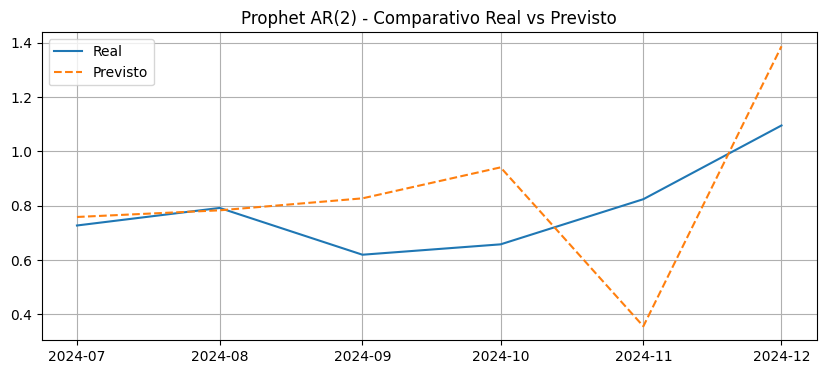

In [30]:
import matplotlib.pyplot as plt

res = resultado['forecast_df']
plt.figure(figsize=(10, 4))
plt.plot(res['ds'], res['y_true'], label='Real')
plt.plot(res['ds'], res['y_pred'], label='Previsto', linestyle='--')
plt.legend()
plt.title('Prophet AR(2) - Comparativo Real vs Previsto')
plt.grid(True)
plt.show()

In [ ]:
m = Prophet(yearly_seasonality=True,
            monthly_seasonality=False, daily_seasonality=False)
m.fit(indicadores_historicos["Lucro_Líquido"])

# Gerar previsões para 12 meses à frente
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Visualizar
m.plot(forecast)
m.plot_components(forecast)

TypeError: __init__() got an unexpected keyword argument 'monthly_seasonality'